In [1]:
import os
import numpy as np

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="2"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from functools import partial
import math
import time as time
from tqdm import tqdm

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(font_scale=1.5)
# plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"

import scipy.io as sio
from astropy.io import fits

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg



True
1
0
NVIDIA A100-PCIE-40GB
Using device: cuda


In [2]:
# Optimisation parameters
options = {"tol": 1e-5, "iter": 12000, "update_iter": 200, "record_iters": False}

# Wavelet parameters
wavs_list = ['db8'] # ["db1", "db4"] 
levels = 4
reg_param = 50. # 2e-2 # 2.e-3



In [4]:
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
# repo_dir = '/Users/tl/Documents/research/repos/proj-convex-UQ/large-scale-UQ'
save_dir = repo_dir + '/debug/sampling-outputs/'
# %%
img_name = 'M31'

# Load img
img_path = '/disk/xray0/tl3/repos/large-scale-UQ/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Loading the image and cast it to float
img = np.copy(img_data[0].data)[0,:,:].astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img

#
myType = torch.float64
myComplexType = torch.complex128

# %%
# Load op from X Cai
mask_path = repo_dir + '/data/operators_masks/fourier_mask.mat'
op_mask = sio.loadmat(mask_path)['Ma']

# Matlab's reshape works with 'F'-like ordering
mat_mask = np.reshape(np.sum(op_mask, axis=0), (256,256), order='F').astype(bool)

# %%

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape)

# %%
dim = 256
phi = luq.operators.MaskedFourier_torch(
    dim=dim, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)


# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))

# %%

# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# g.beta = 1.0 / sigma ** 2


# Define the wavelet dict
# Define the l1 norm with dict psi
# gamma = torch.max(torch.abs(psi.dir_op(y_torch))) * reg_param
psi = luq.operators.DictionaryWv_torch(wavs_list, levels)

h = luq.operators.L1Norm_torch(1., psi, op_to_coeffs=True)
# gamma = h._get_max_abs_coeffs(h.dir_op(torch.clone(x_init))) * reg_param
# h.gamma = gamma
# h.beta = 1.0
h.gamma = reg_param

print('gamma: ', h.gamma)

f = luq.operators.RealProx_torch()



gamma:  50.0


INSTRUME                                                                         [astropy.io.fits.card]


In [5]:
alpha = 0.98 / g.beta

# reg_param = 5.

# h.gamma = reg_param
# print('h.gamma: ', h.gamma)
# print('thresh param: ', h.gamma*alpha)


In [6]:
alpha

5.6448010093690754e-06

In [7]:


x_hat, diagnostics = luq.optim.FB_torch(
    x_init,
    options=options,
    g=g,
    f=f,
    h=h,
    alpha=alpha,
    tau=alpha,
    viewer=None
)


Running Base Forward Backward
[Forward Backward] 0 out of 12000 iterations, tol = 4.03e-01
[Forward Backward] 200 out of 12000 iterations, tol = 3.52e-04
[Forward Backward] 400 out of 12000 iterations, tol = 2.35e-04
[Forward Backward] 600 out of 12000 iterations, tol = 1.77e-04
[Forward Backward] 800 out of 12000 iterations, tol = 1.45e-04
[Forward Backward] 1000 out of 12000 iterations, tol = 1.01e-04
[Forward Backward] 1200 out of 12000 iterations, tol = 5.82e-05
[Forward Backward] 1400 out of 12000 iterations, tol = 2.95e-05
[Forward Backward] 1600 out of 12000 iterations, tol = 1.80e-05
[Forward Backward] converged in 1782 iterations


In [8]:

x_hat_np = luq.utils.to_numpy(x_hat)


Dirty
(PSNR: 27.45,
 SNR: 5.01, SSIM: 0.35)
Reconstruction
(PSNR: 49.86,
 SNR: 27.42, SSIM: 0.99)
Residual (x - x^hat)
(PSNR: 22.46,
 SNR: 0.02, SSIM: 0.77)


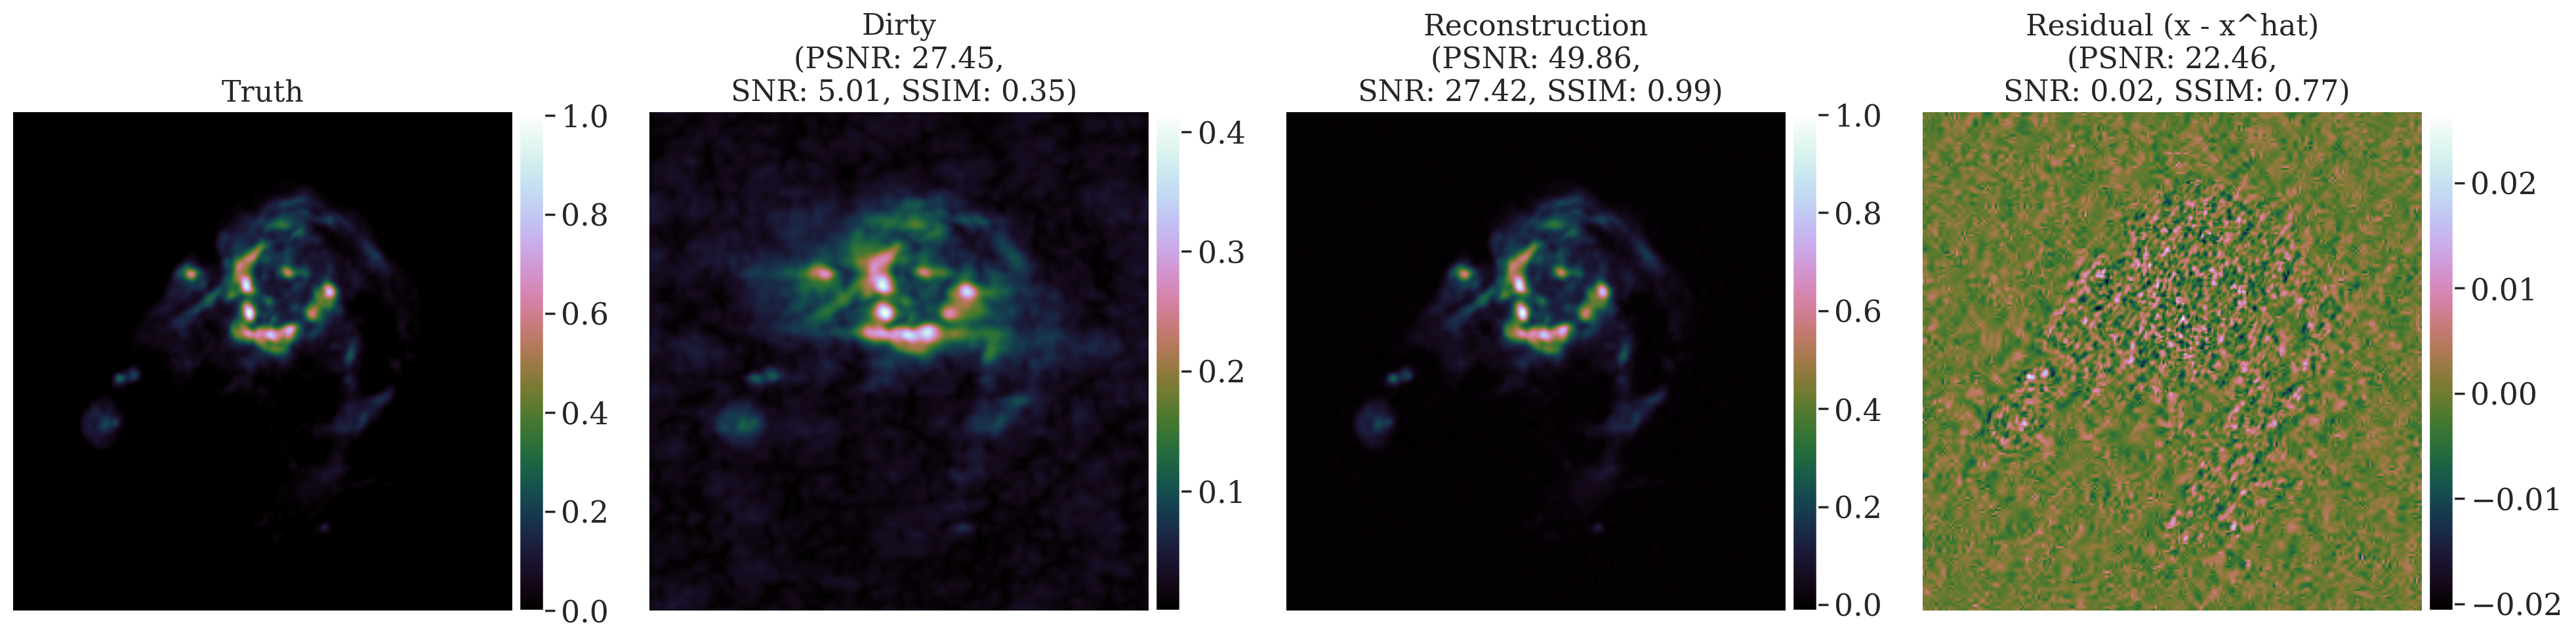

In [9]:
cmap='cubehelix'

# Plot results
images = [
    ground_truth,
    luq.utils.to_numpy(x_init),
    x_hat_np,
    ground_truth - x_hat_np
]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(24,6), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='cubehelix', vmax=np.nanmax(images[i]), vmin=np.nanmin(images[i]))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i > 0:   
        stats_str = '\n(PSNR: {},\n SNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            round(luq.utils.eval_snr(x, images[i]), 2),
            round(ssim(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            )
        labels[i] += stats_str
        print(labels[i])
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
# plt.savefig('{:s}{:s}_MAP.pdf'.format(savefig_dir, save_name))
# plt.close()
plt.show()


In [41]:



# Sampling alg params
frac_burnin = 0.1
n_samples = np.int64(1e2)
thinning = np.int64(5e1)
maxit = np.int64(n_samples * thinning * (1. + frac_burnin))

# frac_delta = 0.1



In [42]:
# lambda_prox = 1. / L_likelihood
# lambd_frac = 0.99
# lambd = lambda_prox * lambd_frac

L_likelihood = g.beta
frac_delta = 0.98

lmbd = 1 / L_likelihood
print('lmbd: ', lmbd)

L_g = 1 / lmbd
L = L_g + L_likelihood
delta = frac_delta / L
print('delta: ', delta)
print('h.gamma: ', h.gamma)
print('prox thresh: ', h.gamma*lmbd)

lmbd:  5.760001029968445e-06
delta:  2.8224005046845377e-06
h.gamma:  50.0
prox thresh:  0.00028800005149842223


In [43]:
h.gamma = 50.

In [44]:

# frac_delta = 0.5 # (should be between [0.2, 0.5])

# L_likelihood = g.beta
# delta = frac_delta / L_likelihood
# print('delta', delta)

# lmbd = 2 / L_likelihood
# print('lmbd: ', lmbd)

# print('prox thresh: ', h.gamma*lmbd)

In [45]:
# L_likelihood = g.beta

# # delta = 1 / (L_likelihood + 1/lmbd)
# frac_delta = 0.5
# delta = frac_delta / (L_likelihood)
# lmbd = 3. * delta

# # lmbd = 0.9 / L_likelihood
# # delta = 1 / (L_likelihood + 1/lmbd)

# # reg_param = 10.
# gamma = h._get_max_abs_coeffs(h.dir_op(torch.clone(x_init))) * reg_param
# h.gamma = gamma

# print('lmbd: ', lmbd)
# print('delta', delta)
# print('prox thresh: ', h.gamma*lmbd/2)
# print('(1. - (delta / lmbd)) ', (1. - (delta/lmbd)))

In [46]:
# Define likelihood functions
fun_likelihood = lambda _x : g.fun(_x)
grad_likelihood = lambda _x : g.grad(_x)

# Define prior


fun_prior = lambda _x : h._fun_coeffs(h.dir_op(_x))

# prox_prior = lambda _x, lmbd : h.adj_op(h.prox(h.dir_op(torch.clone(_x)), lmbd))
# grad_prior = lambda _x, lmbd : (_x - prox_prior(_x, lmbd)) / lmbd 

sub_op = lambda _x1, _x2 : _x1 - _x2
prox_prior_cai = lambda _x, lmbd : torch.clone(_x) + h.adj_op(h._op_to_two_coeffs(h.prox(h.dir_op(_x), lmbd), h.dir_op(_x), sub_op))
prox_prior_2 = lambda _x, lmbd : h.adj_op(h.prox(h.dir_op(torch.clone(_x)), lmbd))


# h.gamma = h._get_max_abs_coeffs(h.dir_op(torch.clone(x_init))) * reg_param

# Define posterior and gradient
logPi = lambda _z :  fun_likelihood(_z) + fun_prior(_z)
# grad_likelihood_prior = lambda _x, lmbd : torch.real(grad_likelihood(_x) + grad_prior(_x, lmbd))

# proxH = lambda X, mu : 

# drift = lambda X, lmbd2, mu : torch.real(
#     (1-lmbd2/mu)*X + (lmbd2/mu)*prox_prior(X,mu) + (lmbd2/2)*grad_likelihood(X)
# )



In [47]:
print('h.gamma ', h.gamma)
print('lmbd ', lmbd)
print('delta ', delta)
print('thresh ', h.gamma*lmbd)
print('(1. - (delta / lmbd)) ', (1. - (delta/lmbd)))

h.gamma  50.0
lmbd  5.760001029968445e-06
delta  2.8224005046845377e-06
thresh  0.00028800005149842223
(1. - (delta / lmbd))  0.51


In [48]:

def MYULA_kernel(X, delta, lmbd, grad_likelihood, prox_prior):
    return torch.real((1. - (delta/lmbd)) * torch.clone(X) - delta * grad_likelihood(torch.clone(X)) + (delta/lmbd) * prox_prior(X, lmbd)) + math.sqrt(2*delta) * torch.randn_like(X)

def MYULA_kernel_2(X, delta, lmbd, grad_likelihood, prox_prior):
    return (1. - (delta/lmbd)) * torch.clone(X) + torch.real(
        - delta * grad_likelihood(X) + (delta/lmbd) * prox_prior(X, lmbd)
    ) + math.sqrt(2*delta) * torch.randn_like(X)



In [49]:
# # Define kernel
# def ULA_drift_kernel(X, drift, lmbd, mu):
#     return drift(X, lmbd, mu) + math.sqrt(2*lmbd) * torch.randn_like(X)

# # Define kernel
# def ULA_kernel(X, delta):
#     return X - delta * grad_likelihood_prior(X) + math.sqrt(2*delta) * torch.randn_like(X)



In [50]:
# L_prior = 1 / lambd
# L = L_likelihood + L_prior
# delta = 1. * frac_delta / L

# print('delta: ', delta)


In [38]:
# Sampling alg params
burnin = np.int64(n_samples * thinning * frac_burnin)
X = x_init.clone()
MC_X = np.zeros((n_samples, X.shape[1], X.shape[2]))
logpi_thinning_trace = np.zeros((n_samples-1, 1))
thinned_trace_counter = 0
# thinning_step = np.int64(maxit/n_samples)

psnr_values = []
ssim_values = []
logpi_eval = []

# %%
start_time = time.time()
for i_x in tqdm(range(maxit)):

    # Update X
    # X = luq.sampling.ULA_kernel(X, delta, grad_likelihood_prior)
    # X = MYULA_kernel(X, delta, lmbd, grad_likelihood, prox_prior)
    X = MYULA_kernel_2(X, delta, lmbd, grad_likelihood, prox_prior_cai)
    # X = MYULA_kernel_2(X, delta, lmbd, grad_likelihood, prox_prior_2)

    if i_x == burnin:
        # Initialise recording of sample summary statistics after burnin period
        post_meanvar = luq.utils.welford(X)
        absfouriercoeff = luq.utils.welford(torch.fft.fft2(X).abs())
    elif i_x > burnin:
        # update the sample summary statistics
        post_meanvar.update(X)
        absfouriercoeff.update(torch.fft.fft2(X).abs())

        # collect quality measurements
        current_mean = post_meanvar.get_mean()
        psnr_values.append(peak_signal_noise_ratio(current_mean, torch_img).item())
        ssim_values.append(structural_similarity_index_measure(current_mean, torch_img).item())
        logpi_eval.append(logPi(X).item())

        # collect thinned trace
        if np.mod(i_x - burnin, thinning) == 0:
            MC_X[thinned_trace_counter] = X.detach().cpu().numpy()
            logpi_thinning_trace[thinned_trace_counter] = logPi(X).item()
            thinned_trace_counter += 1

end_time = time.time()
elapsed = end_time - start_time    

current_mean = post_meanvar.get_mean()
current_var = post_meanvar.get_var().detach().cpu().squeeze()



100%|██████████| 5500/5500 [00:52<00:00, 105.04it/s]


In [39]:

X

tensor([[[[-0.0371, -0.0008, -0.0393,  ...,  0.0116, -0.0673,  0.0285],
          [-0.0077, -0.0448, -0.0231,  ...,  0.0116,  0.0092,  0.0192],
          [ 0.0246, -0.0125, -0.0242,  ...,  0.0291, -0.0020, -0.0483],
          ...,
          [-0.0460, -0.0349,  0.0080,  ..., -0.0018, -0.0620,  0.0630],
          [ 0.0491,  0.0043,  0.0141,  ...,  0.0330,  0.0245, -0.0361],
          [-0.0235, -0.0059, -0.0036,  ..., -0.0112, -0.0095,  0.0173]]]],
       device='cuda:0', dtype=torch.float64)

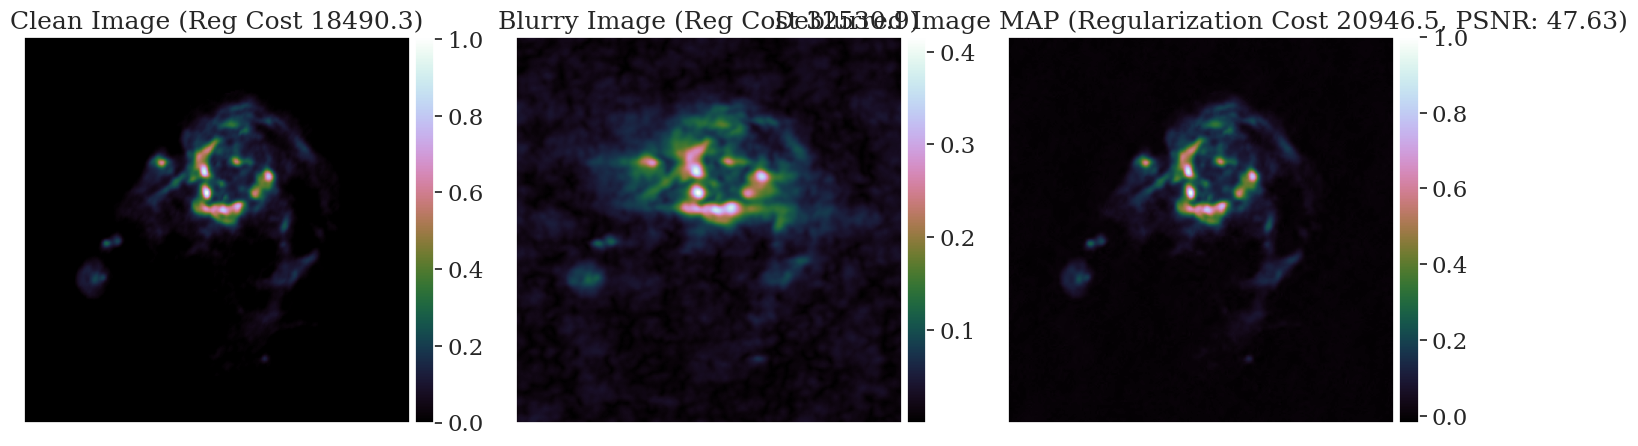

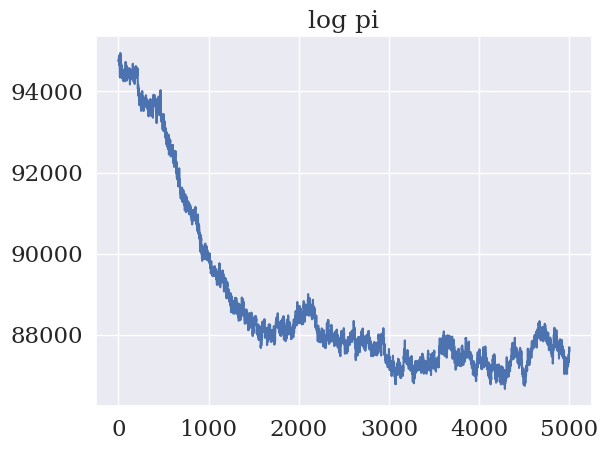

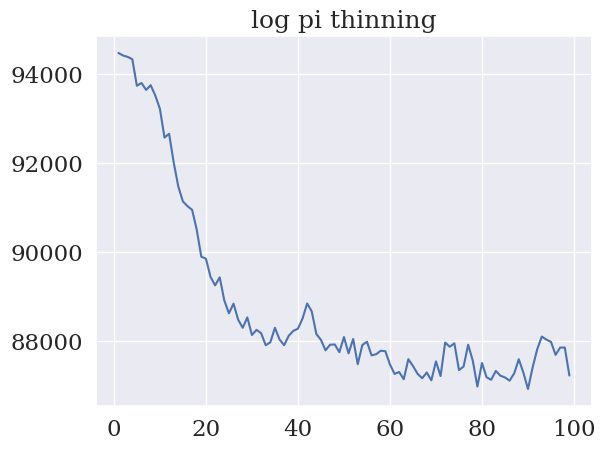

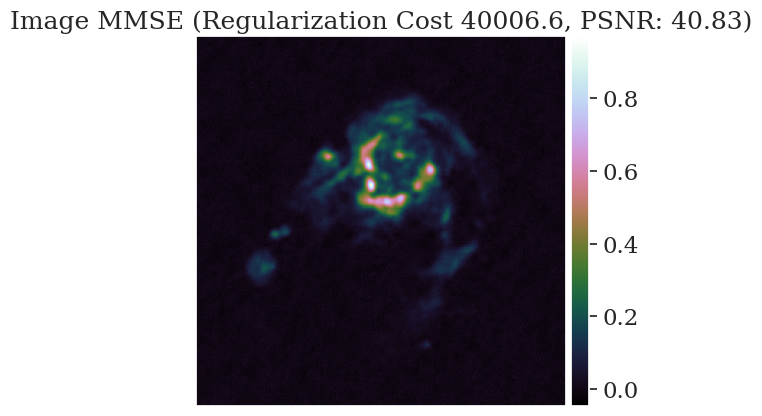

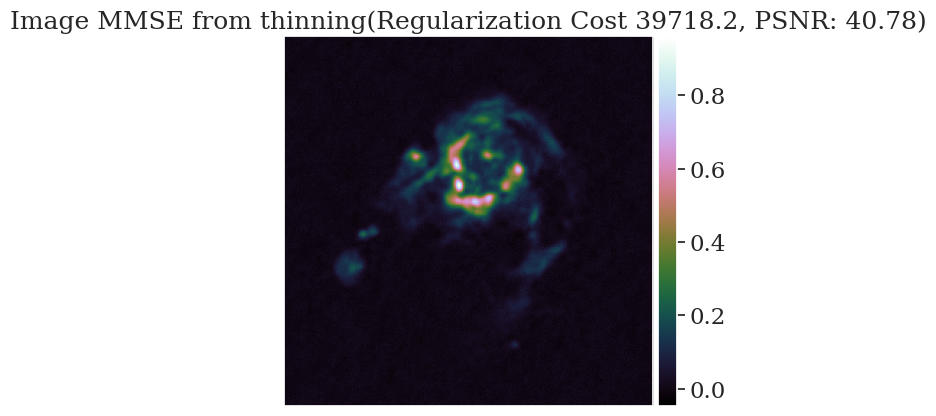

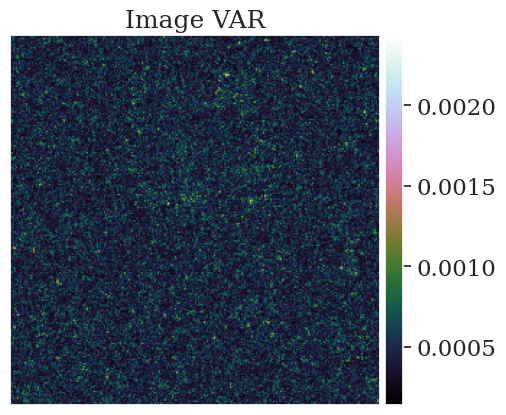

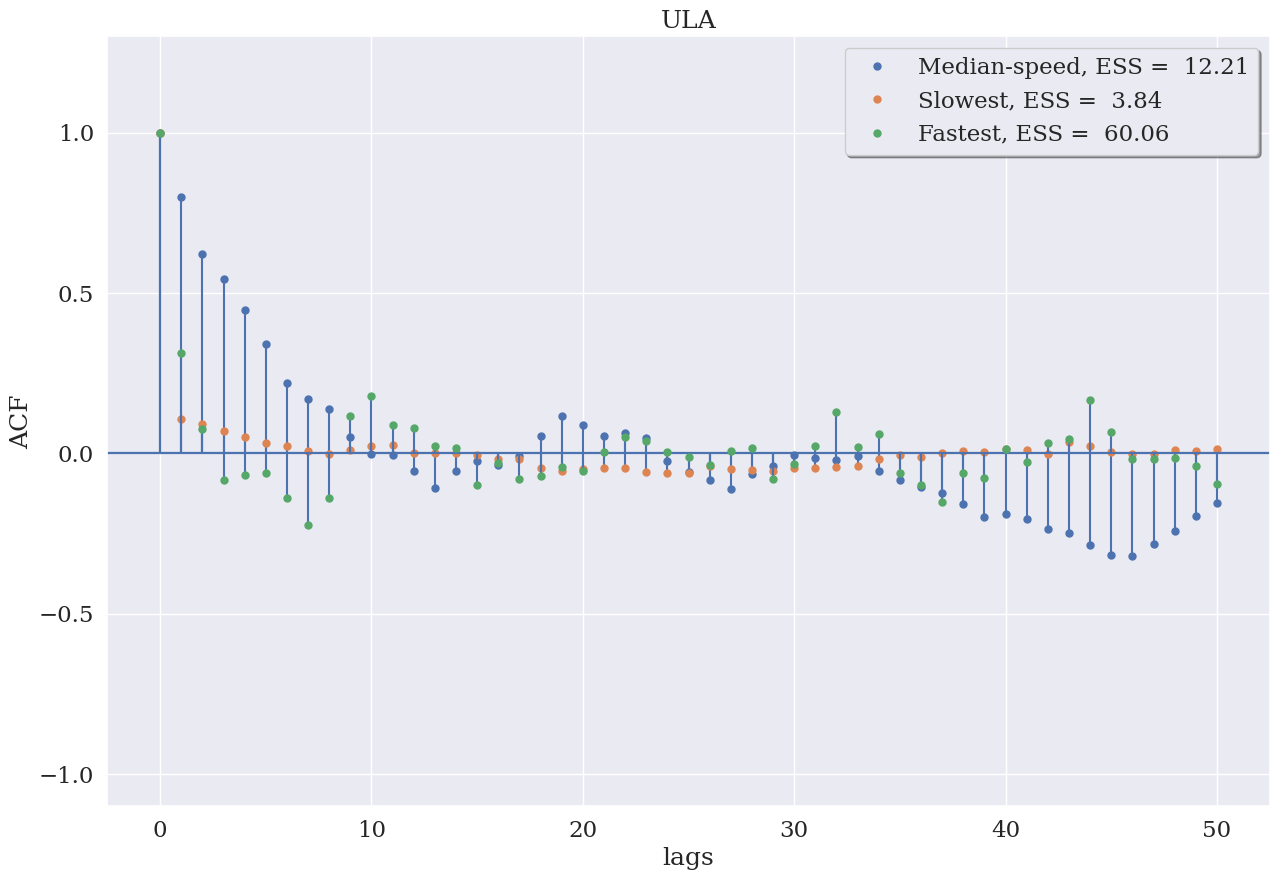

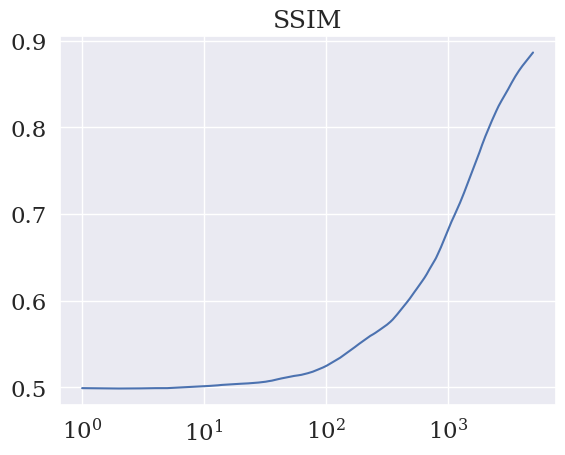

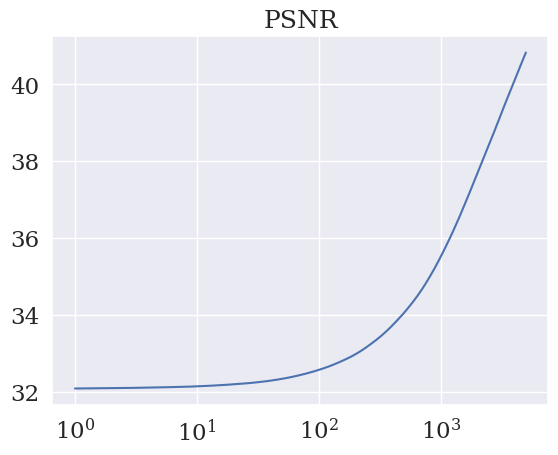

In [40]:


cmap='cubehelix'

savefig_dir = save_dir + 'figs/'

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
ax[0].set_title(f"Clean Image (Reg Cost {fun_prior(torch_img):.1f})")
im = ax[0].imshow(torch_img.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[0].set_yticks([]);ax[0].set_xticks([])

ax[1].set_title(f"Blurry Image (Reg Cost {fun_prior(x_init):.1f})")
im = ax[1].imshow(x_init.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[1].set_yticks([]);ax[1].set_xticks([])

ax[2].set_title(f"Deblurred Image MAP (Regularization Cost {fun_prior(x_hat):.1f}, PSNR: {peak_signal_noise_ratio(x_hat, torch_img).item():.2f})")
im = ax[2].imshow(x_hat.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[2].set_yticks([]);ax[2].set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_MAP_optim.pdf')
plt.show()
# plt.close()


fig, ax = plt.subplots()
ax.set_title("log pi")
ax.plot(np.arange(1,len(logpi_eval)+1), logpi_eval)
# plt.savefig(savefig_dir+save_prefix+'_log_pi_sampling.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title("log pi thinning")
ax.plot(np.arange(1,len(logpi_thinning_trace)+1), logpi_thinning_trace)
# plt.savefig(savefig_dir+save_prefix+'_log_pi_thinning_sampling.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title(f"Image MMSE (Regularization Cost {fun_prior(current_mean):.1f}, PSNR: {peak_signal_noise_ratio(current_mean, torch_img).item():.2f})")
im = ax.imshow(current_mean.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_MMSE_sampling.pdf')
plt.show()
# plt.close()


MC_X_mean = np.mean(MC_X, axis=0)

fig, ax = plt.subplots()
ax.set_title(f"Image MMSE from thinning(Regularization Cost {fun_prior(to_tensor(MC_X_mean, device=device)):.1f}, PSNR: {peak_signal_noise_ratio(to_tensor(MC_X_mean, device=device), torch_img).item():.2f})")
im = ax.imshow(MC_X_mean, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([])
ax.set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_MMSE_thinning_sampling.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title(f"Image VAR")
im = ax.imshow(current_var, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_variance_sampling.pdf')
plt.show()
# plt.close()

luq.utils.autocor_plots(
    MC_X,
    current_var,
    "ULA",
    nLags=50,
    # save_path=savefig_dir+save_prefix+'_autocorr_plot.pdf'
)

fig, ax = plt.subplots()
ax.set_title("SSIM")
ax.semilogx(np.arange(1,len(ssim_values)+1), ssim_values)
# plt.savefig(savefig_dir+save_prefix+'_SSIM_evolution.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title("PSNR")
ax.semilogx(np.arange(1,len(psnr_values)+1), psnr_values)
# plt.savefig(savefig_dir+save_prefix+'_PSNR_evolution.pdf')
plt.show()
# plt.close()



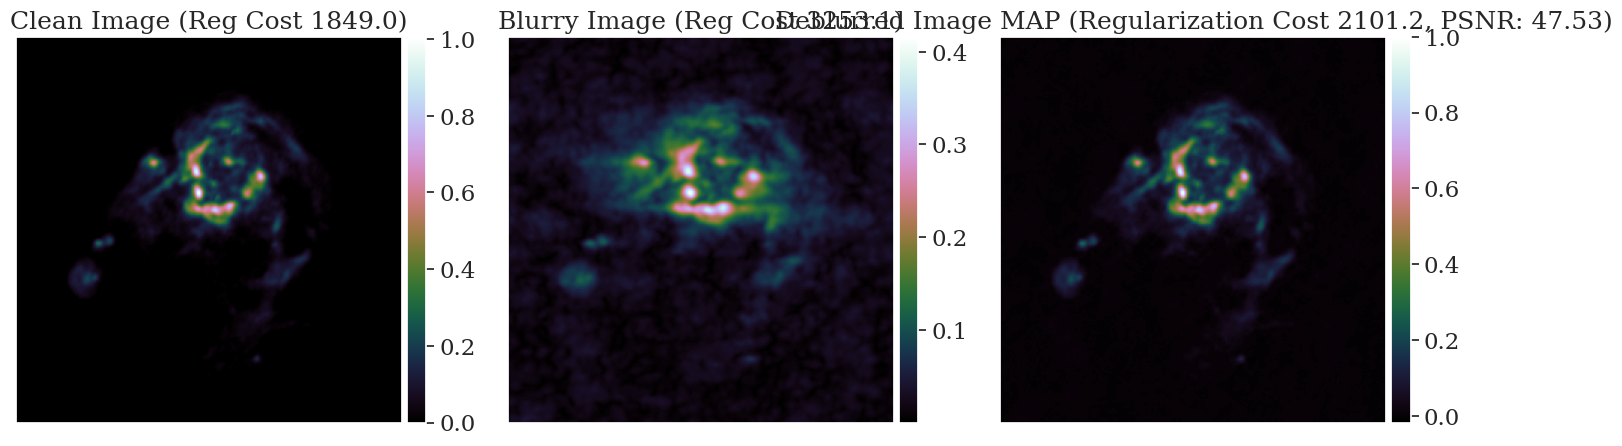

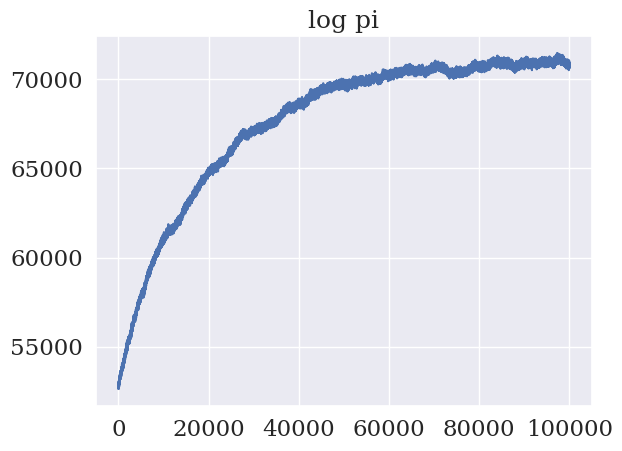

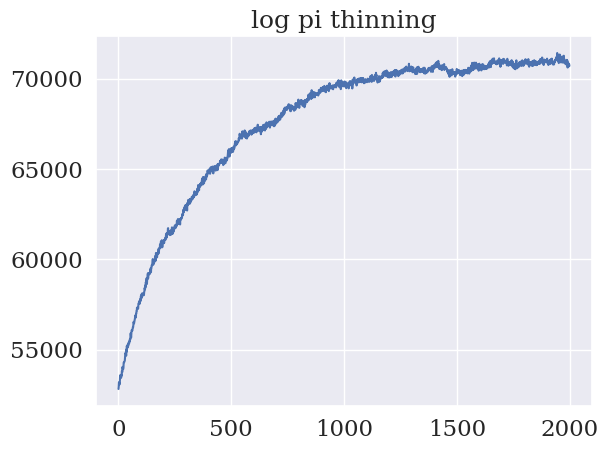

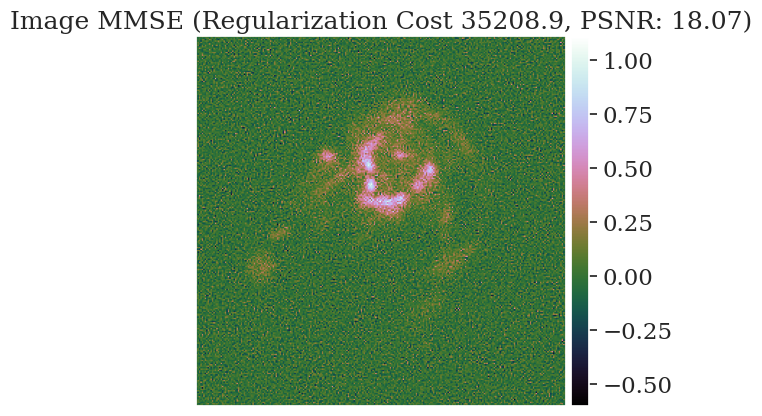

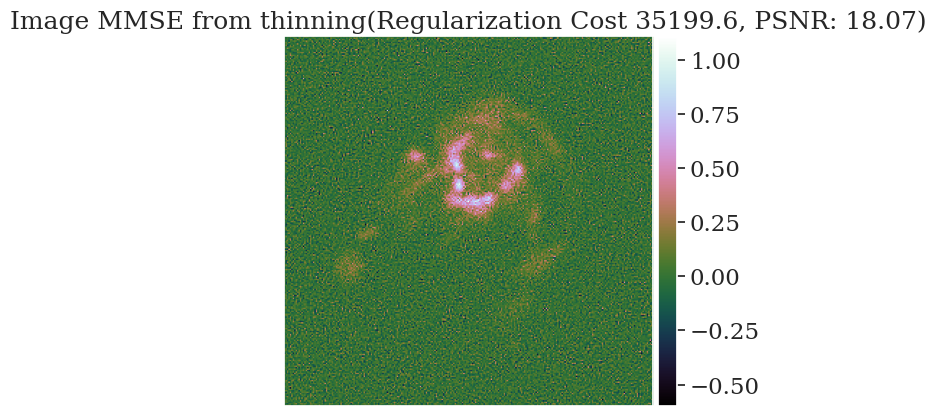

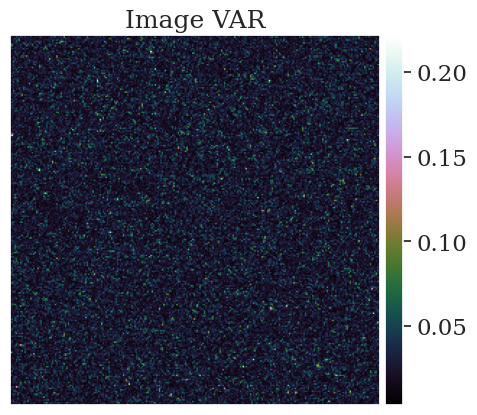

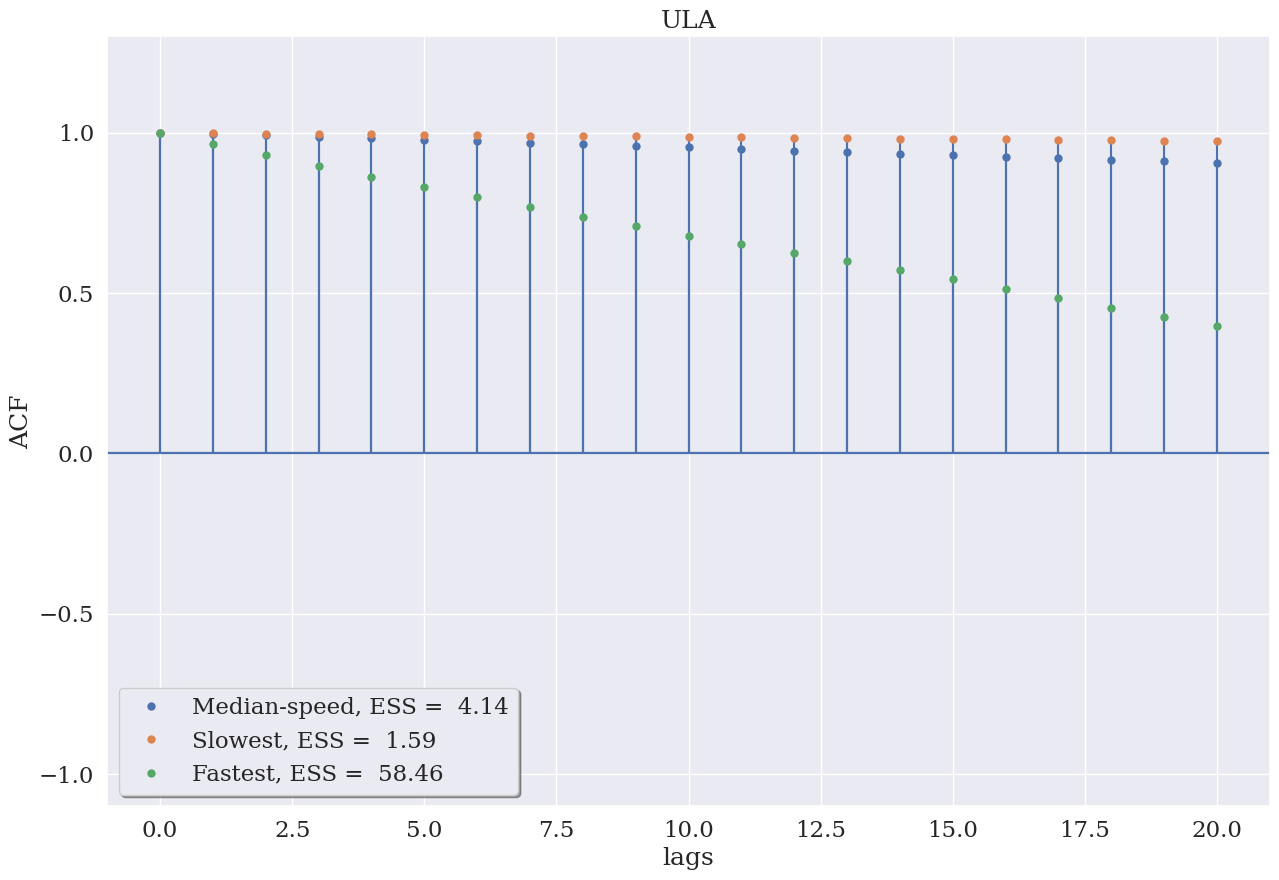

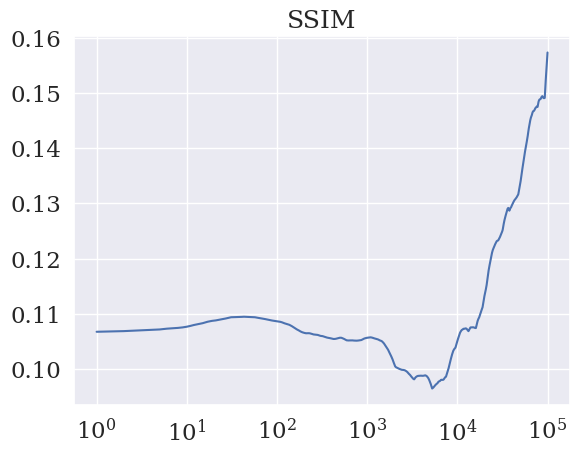

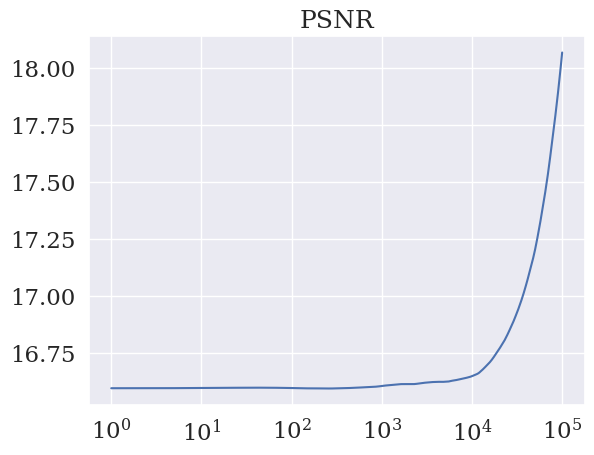

In [81]:


cmap='cubehelix'

savefig_dir = save_dir + 'figs/'

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
ax[0].set_title(f"Clean Image (Reg Cost {fun_prior(torch_img):.1f})")
im = ax[0].imshow(torch_img.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[0].set_yticks([]);ax[0].set_xticks([])

ax[1].set_title(f"Blurry Image (Reg Cost {fun_prior(x_init):.1f})")
im = ax[1].imshow(x_init.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[1].set_yticks([]);ax[1].set_xticks([])

ax[2].set_title(f"Deblurred Image MAP (Regularization Cost {fun_prior(x_hat):.1f}, PSNR: {peak_signal_noise_ratio(x_hat, torch_img).item():.2f})")
im = ax[2].imshow(x_hat.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[2].set_yticks([]);ax[2].set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_MAP_optim.pdf')
plt.show()
# plt.close()


fig, ax = plt.subplots()
ax.set_title("log pi")
ax.plot(np.arange(1,len(logpi_eval)+1), logpi_eval)
# plt.savefig(savefig_dir+save_prefix+'_log_pi_sampling.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title("log pi thinning")
ax.plot(np.arange(1,len(logpi_thinning_trace)+1), logpi_thinning_trace)
# plt.savefig(savefig_dir+save_prefix+'_log_pi_thinning_sampling.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title(f"Image MMSE (Regularization Cost {fun_prior(current_mean):.1f}, PSNR: {peak_signal_noise_ratio(current_mean, torch_img).item():.2f})")
im = ax.imshow(current_mean.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_MMSE_sampling.pdf')
plt.show()
# plt.close()


MC_X_mean = np.mean(MC_X, axis=0)

fig, ax = plt.subplots()
ax.set_title(f"Image MMSE from thinning(Regularization Cost {fun_prior(to_tensor(MC_X_mean, device=device)):.1f}, PSNR: {peak_signal_noise_ratio(to_tensor(MC_X_mean, device=device), torch_img).item():.2f})")
im = ax.imshow(MC_X_mean, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([])
ax.set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_MMSE_thinning_sampling.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title(f"Image VAR")
im = ax.imshow(current_var, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_variance_sampling.pdf')
plt.show()
# plt.close()

luq.utils.autocor_plots(
    MC_X,
    current_var,
    "ULA",
    nLags=20,
    # save_path=savefig_dir+save_prefix+'_autocorr_plot.pdf'
)

fig, ax = plt.subplots()
ax.set_title("SSIM")
ax.semilogx(np.arange(1,len(ssim_values)+1), ssim_values)
# plt.savefig(savefig_dir+save_prefix+'_SSIM_evolution.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title("PSNR")
ax.semilogx(np.arange(1,len(psnr_values)+1), psnr_values)
# plt.savefig(savefig_dir+save_prefix+'_PSNR_evolution.pdf')
plt.show()
# plt.close()


